In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests

import scipy.stats as si

import datetime
from tqdm import tqdm




In [4]:
!pip install gql
!pip install requests_toolbelt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.0 MB/s eta 0:00:00


In [5]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [6]:
def BSM_Price(S, K, T, r, sigma, putcall):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if putcall == 'C':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif putcall == 'P':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    return result

def BSM_IV(S, K, T, r, price, putcall):
    thisIV = 1
    dIV = 0.01
    thresholdPx = 0.001
    for i in range(20):
        thisPx = BSM_Price(S, K, T, r, thisIV, putcall)
        dPx = BSM_Price(S, K, T, r, thisIV + dIV, putcall) - thisPx
        thisIV = thisIV + (price - thisPx) / dPx * dIV
        if dPx <= thresholdPx:
            break
    return thisIV

In [7]:
def DateStrToInt(dateStr):
    return (datetime.datetime.strptime(dateStr + 'UTC08', '%d%b%y%Z%H') - datetime.datetime.utcnow()).total_seconds() / 86400

def GetOptionBook():
    urlOptionBook = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency=ETH&kind=option"
    jsonOptionBook = requests.get(url = urlOptionBook).json() 
    resultOptionBook = jsonOptionBook['result']
    for i in resultOptionBook:
        instrument_name = i['instrument_name']
        instrument_data = instrument_name.split("-")
        underlying = instrument_data[0]
        expiry = instrument_data[1]
        strike = float(instrument_data[2])
        putcall = instrument_data[3]
        TTM = DateStrToInt(expiry)/365.25
        underlying_price = float(i['underlying_price'])
        bid_price = i['bid_price']
        ask_price = i['ask_price']
        mid_price = i['mid_price']

        if bid_price==None:
            i['bid_IV'] = None
        else:
            i['bid_IV'] = BSM_IV(underlying_price,strike,TTM,0,float(bid_price)*underlying_price,putcall)

        if ask_price==None:
            i['ask_IV'] = None
        else:
            i['ask_IV'] = BSM_IV(underlying_price,strike,TTM,0,float(ask_price)*underlying_price,putcall)

        if mid_price==None:
            i['mid_IV'] = None
        else:
            i['mid_IV'] = BSM_IV(underlying_price,strike,TTM,0,float(mid_price)*underlying_price,putcall)
        #print(i['mid_IV'] )

    return resultOptionBook
    #print([i['instrument_name'] for i in resultOptionBook])

def GetOptionMeta():
    urlOptionBook = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency=ETH&kind=option"
    jsonOptionBook = requests.get(url = urlOptionBook).json() 
    resultOptionBook = jsonOptionBook['result']
    dictMeta = {'Strike':[],'Expiry':[]}
    for i in resultOptionBook:

        instrument_name = i['instrument_name']
        instrument_data = instrument_name.split("-")
        expiry = instrument_data[1]
        strike = float(instrument_data[2])
        if not strike in dictMeta['Strike']:
            dictMeta['Strike'].append(strike)
        if not expiry in dictMeta['Expiry']:
            dictMeta['Expiry'].append(expiry)
        if not strike in dictMeta:
            dictMeta[strike]=[]
        if not expiry in dictMeta:
            dictMeta[expiry]=[]
        if not strike in dictMeta[expiry]:
            dictMeta[expiry].append(strike)
        if not expiry in dictMeta[strike]:
            dictMeta[strike].append(expiry)
        dictMeta['Strike'].sort()
    return dictMeta

OptionMeta = GetOptionMeta()
OptionBook = GetOptionBook()

# thisExpiry = "25NOV22"

# thisStrikes = [thisExpiry+"-"+str(int(i)) for i in sorted(OptionMeta[thisExpiry])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [35]:
# EXPIRIES = ['13NOV22', '18NOV22', '25NOV22', '30DEC22', '27JAN23', '31MAR23', '30JUN23', '29SEP23']
# DAYS_TO_EXPIRATION = [1, 7, 14, 49, 77, 140, 231, 322]

DAYS_TO_EXPIRATION = {'14NOV22': 1, '18NOV22': 4, '25NOV22':11, '30DEC22':47, '27JAN23':75, '31MAR23':138, '30JUN23':229, '29SEP23':320}

EXPIRIES  = list(DAYS_TO_EXPIRATION.keys())



In [36]:

col_names = ['full name', 'type','expiry', 'strike', 'bid price', 'bid IV', 'ask price', 'ask IV', 'mid price', 'mid IV', 'underlying_price']

options_data = pd.DataFrame([], columns=col_names)

for thisExpiry in tqdm(EXPIRIES):
    fullNames = ["ETH-"+thisExpiry+"-"+str(int(i)) for i in sorted(OptionMeta[thisExpiry])]
    strikes = [str(int(i)) for i in sorted(OptionMeta[thisExpiry])]

    for i in (range(len(fullNames))):
#         print(fullNames[i])
        thisPut = [item for item in OptionBook if item.get('instrument_name')==fullNames[i]+"-P"][0]
#         print(thisPut)
        thisCall = [item for item in OptionBook if item.get('instrument_name')==fullNames[i]+"-C"][0]
#         print([fullNames[i], thisExpiry, strikes[i], thisPut['bid_IV'], thisCall['bid_IV'], thisPut['ask_IV'], thisCall['ask_IV']])
        row1 = pd.DataFrame([[fullNames[i], 'put',thisExpiry, strikes[i], thisPut['bid_price'], thisPut['bid_IV'], thisPut['ask_price'], thisPut['ask_IV'], thisPut['mid_price'], thisPut['mid_IV'], thisPut['underlying_price']]], columns=col_names)
        row2 = pd.DataFrame([[fullNames[i], 'call', thisExpiry, strikes[i], thisCall['bid_price'], thisCall['bid_IV'], thisCall['ask_price'], thisCall['ask_IV'], thisCall['mid_price'], thisCall['mid_IV'], thisCall['underlying_price']]], columns=col_names)

        options_data = pd.concat([options_data, row1], ignore_index=True)
        options_data = pd.concat([options_data, row2], ignore_index=True)




100%|██████████| 8/8 [00:01<00:00,  6.91it/s]


In [37]:
options_data.head()

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price
0,ETH-14NOV22-600,put,14NOV22,600,NaN,NaN,0.001,5539883405322221097396233742166822878174343375...,NaN,NaN,1188.186893
1,ETH-14NOV22-600,call,14NOV22,600,NaN,NaN,NaN,NaN,NaN,NaN,1188.186893
2,ETH-14NOV22-700,put,14NOV22,700,NaN,NaN,0.001,8376021616903513333490298748790912364605735652...,NaN,NaN,1188.186893
3,ETH-14NOV22-700,call,14NOV22,700,NaN,NaN,NaN,NaN,NaN,NaN,1188.186893
4,ETH-14NOV22-800,put,14NOV22,800,NaN,NaN,0.001,4500981951722297421652869648480446224781017088...,NaN,NaN,1188.186893


In [38]:
DAYS_IN_YEAR = 365.25

options_data['expiry in years'] = options_data['expiry'].apply(lambda x: DAYS_TO_EXPIRATION[x] / DAYS_IN_YEAR )

In [52]:
day = '25NOV22'

In [53]:
options_data_on_day = options_data[(options_data['expiry']) == day]



In [54]:
options_data_on_day.replace(to_replace=[None], value=np.nan, inplace=True)

In [55]:
options_data_on_day['strike'] = options_data_on_day['strike'].apply(lambda x: float(x))

options_data_on_day['bid IV'] = options_data_on_day['bid IV'].apply(lambda x: float(x))
options_data_on_day['ask IV'] = options_data_on_day['ask IV'].apply(lambda x: float(x))





/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [56]:
options_data_on_day.dtypes

full name            object
type                 object
expiry               object
strike              float64
bid price           float64
bid IV              float64
ask price           float64
ask IV              float64
mid price           float64
mid IV              float64
underlying_price    float64
expiry in years     float64
dtype: object

In [57]:
least_underlying_price = round(options_data_on_day.iloc[1, :]['underlying_price'] / 100) * 100

In [58]:
least_underlying_price

1200

In [103]:
selected_iv = float(options_data_on_day[(options_data_on_day['type'] == 'call') 
                                   & (options_data_on_day['strike'] == least_underlying_price)]['mid IV'])

In [104]:
selected_iv


1.2754083138463213

In [105]:
selected_expiry_years = DAYS_TO_EXPIRATION[day] / 365


In [106]:
from scipy.stats import norm


In [107]:
N = norm.cdf


In [131]:
underlying_price = options_data_on_day.iloc[0, :]['underlying_price']

upper_bound = underlying_price * 1.5
lower_bound = underlying_price / 1.5
print(lower_bound, upper_bound)

786.2066666666666 1768.965


In [132]:
T = selected_expiry_years
sigma = selected_iv 

print(T, sigma)

0.030136986301369864 1.2754083138463213


100%|██████████| 1000/1000 [00:05<00:00, 199.47it/s]


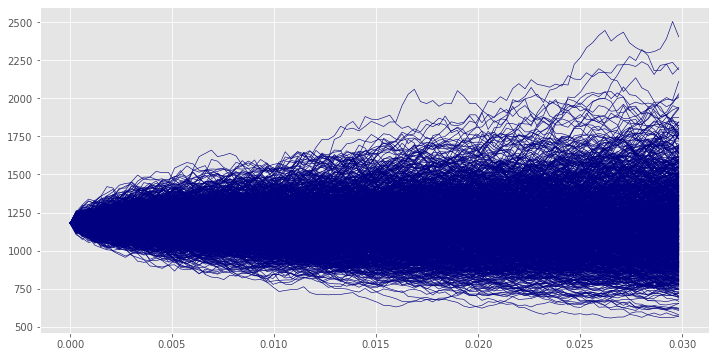

In [133]:
# geometric bwornian motions
# TODO: add taking account of risk-free rate while sampling


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline


steps = 100
num_plots = 1000
Range = []
Values = [underlying_price]


plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


Range = np.arange(steps) / steps * T

all_paths = []

out_of_range_paths = set()

for plot_num in tqdm(range(0, num_plots)):

    for i in range (1, steps):
        dx = sigma * Values[-1] * norm.rvs() * np.sqrt(T / steps)

        y = Values[-1] + dx
        
        if y < lower_bound or y > upper_bound:
            out_of_range_paths.add(plot_num)
        
        Values.append(y)
    all_paths.append(Values)
    ax.plot(Range, Values)
    Values = [underlying_price]



In [134]:
print('probability to go out of range:', len(out_of_range_paths) / num_plots)

probability to go out of range: 0.115
